In [1]:
import os

import pandas as pd
import tiktoken

from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.indexer_adapters import (
    read_indexer_covariates,
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
)
from graphrag.query.input.loaders.dfs import (
    store_entity_semantic_embeddings,
)
from graphrag.query.llm.oai.chat_openai import ChatOpenAI
from graphrag.query.llm.oai.embedding import OpenAIEmbedding
from graphrag.query.llm.oai.typing import OpenaiApiType
from graphrag.query.question_gen.local_gen import LocalQuestionGen
from graphrag.query.structured_search.local_search.mixed_context import (
    LocalSearchMixedContext,
)
from graphrag.query.structured_search.local_search.search import LocalSearch
from graphrag.vector_stores.lancedb import LanceDBVectorStore

/data/yuhui/miniconda3/envs/graphrag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Local Search Example

Local search method generates answers by combining relevant data from the AI-extracted knowledge-graph with text chunks of the raw documents. This method is suitable for questions that require an understanding of specific entities mentioned in the documents (e.g. What are the healing properties of chamomile?).

### Load text units and graph data tables as context for local search

- In this test we first load indexing outputs from parquet files to dataframes, then convert these dataframes into collections of data objects aligning with the knowledge model.

### Load tables to dataframes

In [2]:
# 步骤 1：找到排序最大的文件夹
output_path = "alltest/location_dataset/dataset4/output"
folders = [os.path.join(output_path, d) for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
latest_folder = max(folders, key=os.path.getmtime)

In [3]:
INPUT_DIR = latest_folder + "/artifacts"
LANCEDB_URI = f"{INPUT_DIR}/lancedb"

COMMUNITY_REPORT_TABLE = "create_final_community_reports"
ENTITY_TABLE = "create_final_nodes"
ENTITY_EMBEDDING_TABLE = "create_final_entities"
RELATIONSHIP_TABLE = "create_final_relationships"
COVARIATE_TABLE = "create_final_covariates"
TEXT_UNIT_TABLE = "create_final_text_units"
COMMUNITY_LEVEL = 2

#### Read entities

In [4]:
# read nodes table to get community and degree data
entity_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_TABLE}.parquet")
entity_embedding_df = pd.read_parquet(f"{INPUT_DIR}/{ENTITY_EMBEDDING_TABLE}.parquet")

entities = read_indexer_entities(entity_df, entity_embedding_df, COMMUNITY_LEVEL)

# load description embeddings to an in-memory lancedb vectorstore
# to connect to a remote db, specify url and port values.
description_embedding_store = LanceDBVectorStore(
    collection_name="entity_description_embeddings",
)
description_embedding_store.connect(db_uri=LANCEDB_URI)
entity_description_embeddings = store_entity_semantic_embeddings(
    entities=entities, vectorstore=description_embedding_store
)

print(f"Entity count: {len(entity_df)}")
entity_df.head()

Entity count: 1131


,level,title,type,description,source_id,community,degree,human_readable_id,id,size,graph_embedding,top_level_node_id,x,y
0,0,METROPOLITAN MUSEUM OF ART,ORGANIZATION,"The Metropolitan Museum of Art, also known as ...",4212f9fd0743bef90b03bb610d6fa25a,8,5,0,b45241d70f0e43fca764df95b2b81f77,5.0,"[-0.08402902632951736, 0.0631222203373909, -0....",b45241d70f0e43fca764df95b2b81f77,-0.219977,11.651706
1,0,NEW YORK CITY,GEO,"New York City, often referred to as NYC, is th...","05a3084b7238a6947eb09d148f0fe64e,21c90b0ad75d2...",7,25,1,4119fd06010c494caa07f439b333f4c5,25.0,"[-0.09996693581342697, 0.0779457539319992, -0....",4119fd06010c494caa07f439b333f4c5,-3.010494,12.461647
2,0,THE CLOISTERS,ORGANIZATION,The Cloisters is a branch of the Metropolitan ...,4212f9fd0743bef90b03bb610d6fa25a,8,1,2,d3835bf3dda84ead99deadbeac5d0d7d,1.0,"[-0.0683378130197525, 0.04543682932853699, -0....",d3835bf3dda84ead99deadbeac5d0d7d,0.177832,12.034372
3,0,EMPIRE STATE BUILDING,ORGANIZATION,The Empire State Building is a renowned skyscr...,"4212f9fd0743bef90b03bb610d6fa25a,4c71026214c60...",3,15,3,077d2820ae1845bcbb1803379a3d1eae,15.0,"[-0.12234105914831161, 0.10525287687778473, -0...",077d2820ae1845bcbb1803379a3d1eae,-2.350267,19.939039
4,0,HAMILTON E. JAMES,PERSON,Hamilton E. James is one of the chairs of the ...,4212f9fd0743bef90b03bb610d6fa25a,8,1,4,3671ea0dd4e84c1a9b02c5ab2c8f4bac,1.0,"[-0.06621794402599335, 0.04392342269420624, -0...",3671ea0dd4e84c1a9b02c5ab2c8f4bac,-0.037256,12.016357


In [5]:
entity_embedding_df

,id,name,type,description,human_readable_id,graph_embedding,text_unit_ids,description_embedding
0,b45241d70f0e43fca764df95b2b81f77,METROPOLITAN MUSEUM OF ART,ORGANIZATION,"The Metropolitan Museum of Art, also known as ...",0,"[-0.08402902632951736, 0.0631222203373909, -0....",[4212f9fd0743bef90b03bb610d6fa25a],"[-0.00530951377004385, 0.006086771842092276, 0..."
1,4119fd06010c494caa07f439b333f4c5,NEW YORK CITY,GEO,"New York City, often referred to as NYC, is th...",1,"[-0.09996693581342697, 0.0779457539319992, -0....","[05a3084b7238a6947eb09d148f0fe64e, 21c90b0ad75...","[-0.0015244976384565234, -0.01728472299873829,..."
2,d3835bf3dda84ead99deadbeac5d0d7d,THE CLOISTERS,ORGANIZATION,The Cloisters is a branch of the Metropolitan ...,2,"[-0.0683378130197525, 0.04543682932853699, -0....",[4212f9fd0743bef90b03bb610d6fa25a],"[-0.04293454810976982, 0.006304145324975252, 0..."
3,077d2820ae1845bcbb1803379a3d1eae,EMPIRE STATE BUILDING,ORGANIZATION,The Empire State Building is a renowned skyscr...,3,"[-0.12234105914831161, 0.10525287687778473, -0...","[4212f9fd0743bef90b03bb610d6fa25a, 4c71026214c...","[-0.025276411324739456, -0.023596985265612602,..."
4,3671ea0dd4e84c1a9b02c5ab2c8f4bac,HAMILTON E. JAMES,PERSON,Hamilton E. James is one of the chairs of the ...,4,"[-0.06621794402599335, 0.04392342269420624, -0...",[4212f9fd0743bef90b03bb610d6fa25a],"[-0.013679069466888905, -0.0003370577178429812..."
...,...,...,...,...,...,...,...,...
183,ab3a5a6713244fd595a1ace978c3d960,AL SMITH,PERSON,Al Smith was one of the developers of the Empi...,372,"[-0.0820222795009613, 0.06446267664432526, -0....",[4c71026214c60b14aa786b724eaae972],"[-0.0037724787835031748, -0.05490077659487724,..."
184,02a88c0d128e4586b2f1f64329786d3c,HOMER GAGE BALCOM,PERSON,Homer Gage Balcom was the structural engineer ...,373,"[-0.07458498328924179, 0.05780189856886864, -0...",[4c71026214c60b14aa786b724eaae972],"[0.003931385464966297, 0.02129550650715828, -0..."
185,1ca41537c47c4752a17a44d1d7086d96,STARRETT BROTHERS AND EKEN,ORGANIZATION,Starrett Brothers and Eken were the main contr...,374,"[-0.04565461724996567, 0.0285323653370142, -0....",[4c71026214c60b14aa786b724eaae972],"[-2.9973909931868548e-06, -0.03648796305060387..."
186,7e0d14ca308b4796bdc675a64bd3a36e,CHRYSLER BUILDING,ORGANIZATION,The Chrysler Building is an Art Deco skyscrape...,375,"[-0.04172230511903763, 0.026421833783388138, -...",[4c71026214c60b14aa786b724eaae972],"[-0.00033827044535428286, -0.01550849247723817..."


#### Read relationships

In [6]:
relationship_df = pd.read_parquet(f"{INPUT_DIR}/{RELATIONSHIP_TABLE}.parquet")
relationships = read_indexer_relationships(relationship_df)

print(f"Relationship count: {len(relationship_df)}")
relationship_df.head()

Relationship count: 408


,source,target,weight,description,text_unit_ids,id,human_readable_id,source_degree,target_degree,rank
0,METROPOLITAN MUSEUM OF ART,NEW YORK CITY,9.0,The Metropolitan Museum of Art is located in N...,[4212f9fd0743bef90b03bb610d6fa25a],a80c7c98c0b647f8b9f6f8cc09168e44,0,5,25,30
1,METROPOLITAN MUSEUM OF ART,THE CLOISTERS,8.0,The Cloisters is a branch of the Metropolitan ...,[4212f9fd0743bef90b03bb610d6fa25a],2d66a15939294d21b83b3e277f0a4e46,1,5,1,6
2,METROPOLITAN MUSEUM OF ART,CANDACE BEINECKE,8.0,Candace Beinecke serves as a chair of the Metr...,[4212f9fd0743bef90b03bb610d6fa25a],47f6d6573cf34e1096c95e36251dd60c,2,5,1,6
3,METROPOLITAN MUSEUM OF ART,HAMILTON E. JAMES,8.0,Hamilton E. James serves as a chair of the Met...,[4212f9fd0743bef90b03bb610d6fa25a],2fbd74d5ccca4be99c5257b3ac95cfba,3,5,1,6
4,METROPOLITAN MUSEUM OF ART,MAX HOLLEIN,1.0,Max Hollein is the director of the Metropolita...,[4212f9fd0743bef90b03bb610d6fa25a],a2b1621a3e424ae29a6a73f00edbeca3,4,5,1,6


In [7]:
# covariate_df = pd.read_parquet(f"{INPUT_DIR}/{COVARIATE_TABLE}.parquet")

# claims = read_indexer_covariates(covariate_df)

# print(f"Claim records: {len(claims)}")
# covariates = {"claims": claims}

#### Read community reports

In [8]:
report_df = pd.read_parquet(f"{INPUT_DIR}/{COMMUNITY_REPORT_TABLE}.parquet")
reports = read_indexer_reports(report_df, entity_df, COMMUNITY_LEVEL)

print(f"Report records: {len(report_df)}")
report_df.head()

Report records: 56


,community,full_content,level,rank,title,rank_explanation,summary,findings,full_content_json,id
0,44,# Brooklyn Bridge and Its Historical Significa...,2,8.5,Brooklyn Bridge and Its Historical Significance,The impact severity rating is high due to the ...,The community centers around the Brooklyn Brid...,[{'explanation': 'The Brooklyn Bridge is a his...,"{\n ""title"": ""Brooklyn Bridge and Its Histo...",94b8edcf-304b-4d1a-badc-865424e0d002
1,45,# New York Bridge Company and Tammany Hall\n\n...,2,7.5,New York Bridge Company and Tammany Hall,The impact severity rating is high due to the ...,The community is centered around the New York ...,[{'explanation': 'The New York Bridge Company ...,"{\n ""title"": ""New York Bridge Company and T...",d4952f9b-10bc-4935-85d2-eb3408183495
2,46,# Central Park and Its Influential Figures\n\n...,2,8.5,Central Park and Its Influential Figures,The impact severity rating is high due to Cent...,"Central Park, a major urban park in Manhattan,...",[{'explanation': 'Central Park is recognized a...,"{\n ""title"": ""Central Park and Its Influent...",85b1645a-5325-4e63-b70c-7bb67c1f27fe
3,47,# Manhattan and its Financial Hub\n\nThe commu...,2,9.0,Manhattan and its Financial Hub,The impact severity rating is high due to Manh...,"The community centers around Manhattan, a key ...",[{'explanation': 'Manhattan is one of the five...,"{\n ""title"": ""Manhattan and its Financial H...",bfce72b6-6c7e-4d48-9e57-2b6d78e87f38
4,48,# Centennial Exposition and Philadelphia\n\nTh...,2,6.0,Centennial Exposition and Philadelphia,The impact severity rating is moderate due to ...,The community centers around the Centennial Ex...,[{'explanation': 'The Centennial Exposition wa...,"{\n ""title"": ""Centennial Exposition and Phi...",812785d1-bf42-48e7-bdb1-cce020c3fe3a


In [9]:
report_df.iloc[0,1]

"# Brooklyn Bridge and Its Historical Significance\n\nThe community centers around the Brooklyn Bridge, a historic and iconic structure connecting Manhattan and Brooklyn in New York City. Key figures such as John Augustus Roebling, Washington Roebling, and Emily Warren Roebling played significant roles in its design and construction. The bridge spans the East River and is surrounded by notable neighborhoods like Dumbo, Brooklyn Heights, and Civic Center.\n\n## Brooklyn Bridge as a historic landmark\n\nThe Brooklyn Bridge is a historic and iconic hybrid cable-stayed/suspension bridge that connects the boroughs of Manhattan and Brooklyn in New York City. Opened in 1883, it was the first fixed crossing of the East River and was the longest suspension bridge in the world at the time. Its designation as both a National Historic Landmark and a New York City landmark underscores its architectural and engineering significance [Data: Entities (261); Relationships (14, 316, 332)].\n\n## John Aug

#### Read text units

In [10]:
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/{TEXT_UNIT_TABLE}.parquet")
text_units = read_indexer_text_units(text_unit_df)

print(f"Text unit records: {len(text_unit_df)}")
text_unit_df.head()

Text unit records: 37


,id,text,n_tokens,document_ids,entity_ids,relationship_ids
0,4212f9fd0743bef90b03bb610d6fa25a,Metropolitan Museum of Art\n\nArticle\nTalk\nR...,1193,[0dfdee24ef4be3c5a1612890e73dca3d],"[b45241d70f0e43fca764df95b2b81f77, 4119fd06010...","[a80c7c98c0b647f8b9f6f8cc09168e44, 2d66a159392..."
1,79b86365328956971ad4ea3a93a1b658,been named as one of the Seven Wonders of the...,93,[0dfdee24ef4be3c5a1612890e73dca3d],"[4119fd06010c494caa07f439b333f4c5, 077d2820ae1...","[ec45e1c400654c4f875046926486ded7, 66c3dffb7d7..."
2,05a3084b7238a6947eb09d148f0fe64e,United States\n\nArticle\nTalk\nRead\nView sou...,1200,[27e6a34029058fadc37b0e489aab97cb],"[4119fd06010c494caa07f439b333f4c5, c9632a35146...","[ccbbbcc055c34709abcf103208c2c299, 989add81cf8..."
3,f6015b9e8c6b9888550e5f83dcd5fab3,", 1776. Following its victory in the 1775–1783...",436,[27e6a34029058fadc37b0e489aab97cb],"[e2f5735c7d714423a2c4f61ca2644626, 1c109cfdc37...","[3f3a2d7aa1294116814f0b4d89baa23d, 3073b33926b..."
4,61c69ff648ac6dbcee2475e5a0b5fa7a,Times Square\n\nArticle\nTalk\nRead\nEdit\nVie...,712,[2e662263aace3baef20a1fd8a1cf5d60],"[4119fd06010c494caa07f439b333f4c5, adf4ee3fbe9...","[047cd93e9d704c7d8dadb6e79f9458df, ff74091eaba..."


Graph with 377 nodes and 408 edges


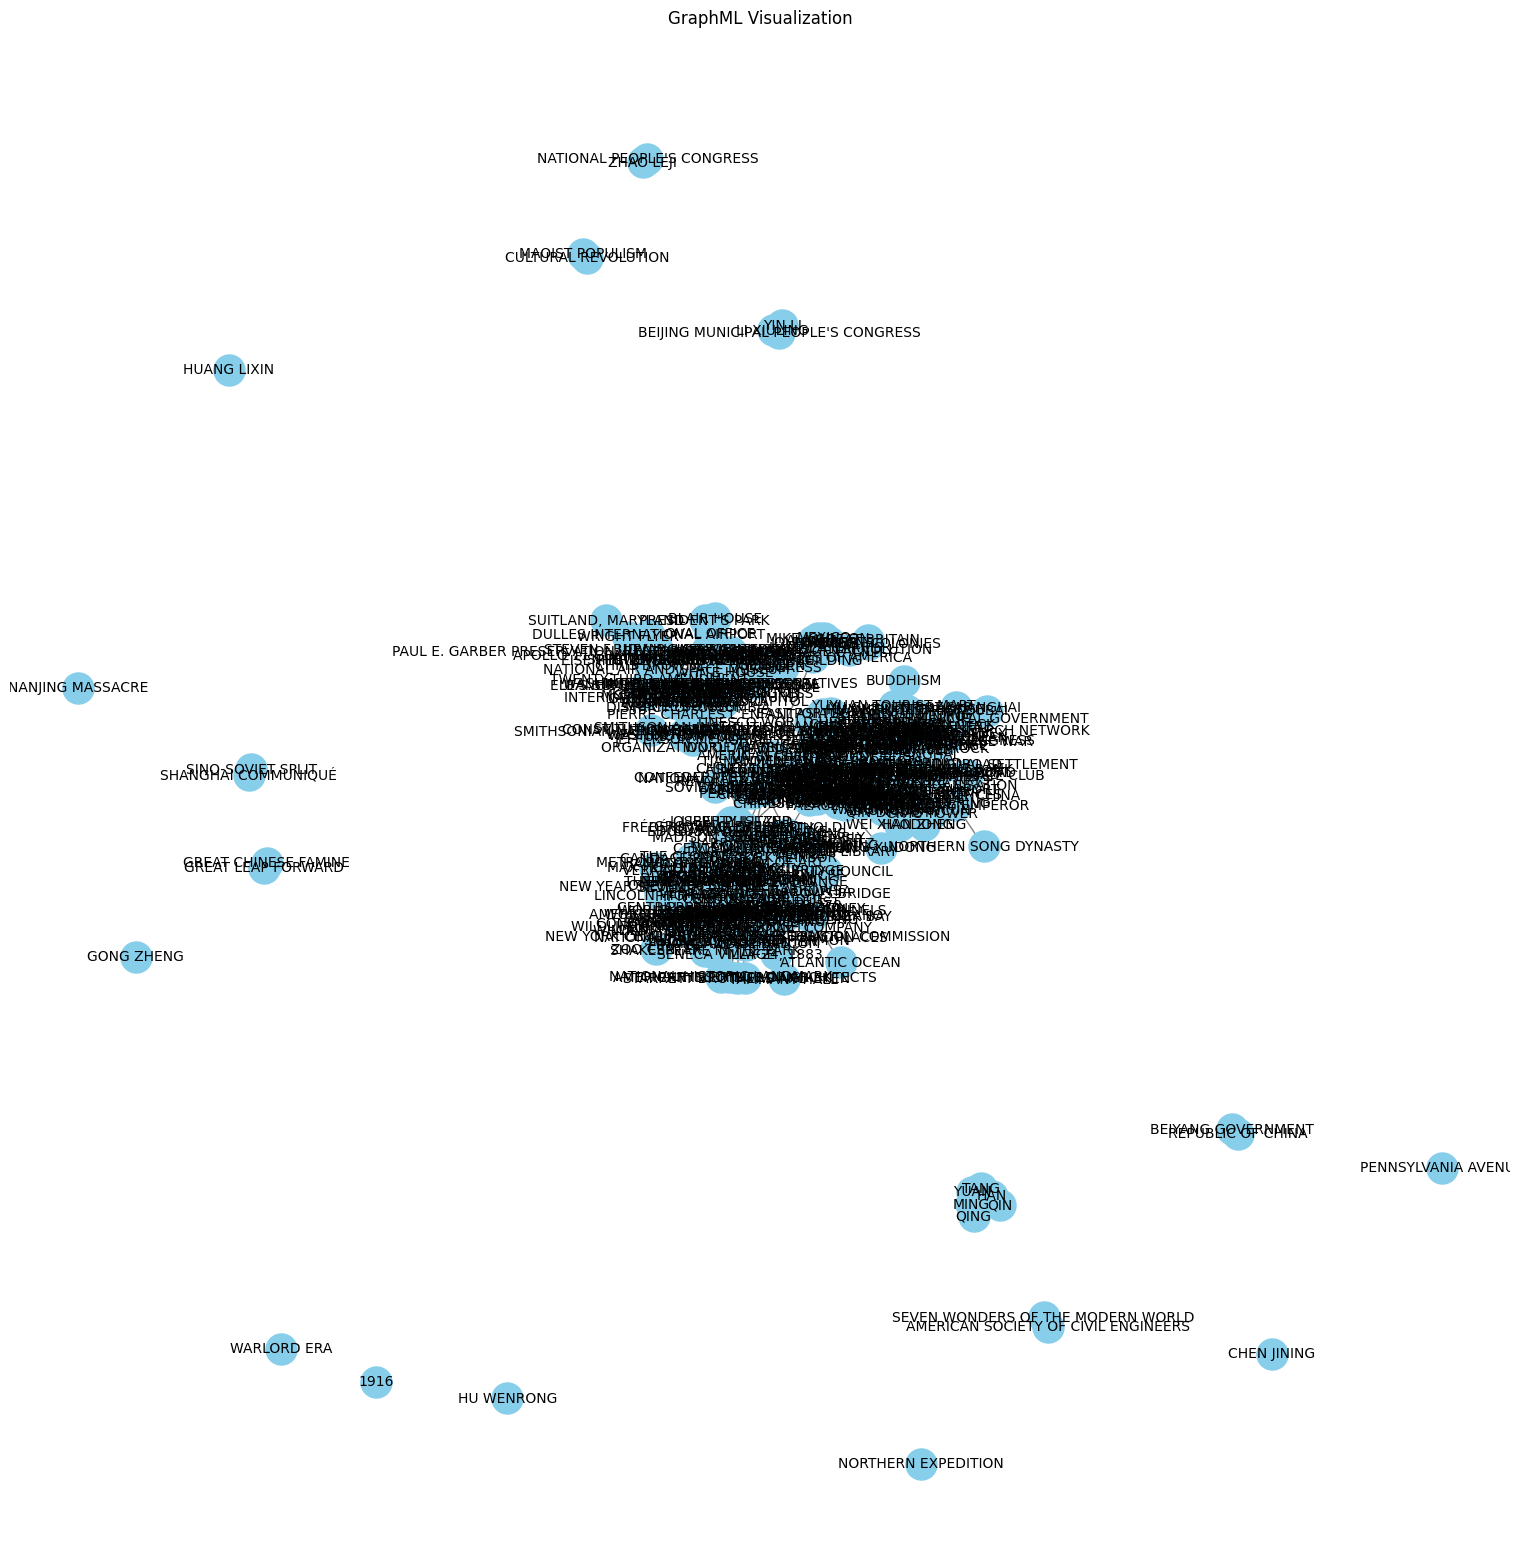

In [11]:
import os
import glob
import networkx as nx
import matplotlib.pyplot as plt

# 步骤 1：找到排序最大的文件夹
output_path = "alltest/location_dataset/dataset4/output"
folders = [os.path.join(output_path, d) for d in os.listdir(output_path) if os.path.isdir(os.path.join(output_path, d))]
latest_folder = max(folders, key=os.path.getmtime)

# 步骤 2：找到该文件夹下的 artifacts/merged_graph.graphml 文件
graphml_file_path = os.path.join(latest_folder, 'artifacts', 'merged_graph.graphml')

# 检查文件是否存在
if not os.path.isfile(graphml_file_path):
    print(f"GraphML 文件未找到: {graphml_file_path}")
else:
    # 步骤 3：读取 GraphML 文件并进行可视化
    graph = nx.read_graphml(graphml_file_path)
    print(graph)
    # # 绘制图形
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph)  # 使用 spring layout 布局
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='regular', edge_color='gray')
    plt.title('GraphML Visualization')
    plt.show()

### Create local search context builder

In [12]:
api_key = os.getenv('OPENAI_API_KEY')
llm_model = "gpt-4o"
embedding_model = "text-embedding-3-small"

llm = ChatOpenAI(
    api_key=api_key,
    model=llm_model,
    api_type=OpenaiApiType.OpenAI,  # OpenaiApiType.OpenAI or OpenaiApiType.AzureOpenAI
    max_retries=20,
)

token_encoder = tiktoken.get_encoding("cl100k_base")

text_embedder = OpenAIEmbedding(
    api_key=api_key,
    api_base=None,
    api_type=OpenaiApiType.OpenAI,
    model=embedding_model,
    deployment_name=embedding_model,
    max_retries=20,
)

In [13]:
context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    # covariates=covariates,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,  # if the vectorstore uses entity title as ids, set this to EntityVectorStoreKey.TITLE
    text_embedder=text_embedder,
    token_encoder=token_encoder,
)

### Create local search engine

In [14]:
# text_unit_prop: proportion of context window dedicated to related text units
# community_prop: proportion of context window dedicated to community reports.
# The remaining proportion is dedicated to entities and relationships. Sum of text_unit_prop and community_prop should be <= 1
# conversation_history_max_turns: maximum number of turns to include in the conversation history.
# conversation_history_user_turns_only: if True, only include user queries in the conversation history.
# top_k_mapped_entities: number of related entities to retrieve from the entity description embedding store.
# top_k_relationships: control the number of out-of-network relationships to pull into the context window.
# include_entity_rank: if True, include the entity rank in the entity table in the context window. Default entity rank = node degree.
# include_relationship_weight: if True, include the relationship weight in the context window.
# include_community_rank: if True, include the community rank in the context window.
# return_candidate_context: if True, return a set of dataframes containing all candidate entity/relationship/covariate records that
# could be relevant. Note that not all of these records will be included in the context window. The "in_context" column in these
# dataframes indicates whether the record is included in the context window.
# max_tokens: maximum number of tokens to use for the context window.


local_context_params = {
    "text_unit_prop": 0.5,
    "community_prop": 0.1,
    "conversation_history_max_turns": 5,
    "conversation_history_user_turns_only": True,
    "top_k_mapped_entities": 10,
    "top_k_relationships": 10,
    "include_entity_rank": True,
    "include_relationship_weight": True,
    "include_community_rank": False,
    "return_candidate_context": False,
    "embedding_vectorstore_key": EntityVectorStoreKey.ID,  # set this to EntityVectorStoreKey.TITLE if the vectorstore uses entity title as ids
    "max_tokens": 12_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 5000)
}

llm_params = {
    "max_tokens": 2_000,  # change this based on the token limit you have on your model (if you are using a model with 8k limit, a good setting could be 1000=1500)
    "temperature": 0.0,
}

In [15]:
search_engine = LocalSearch(
    llm=llm,
    context_builder=context_builder,
    token_encoder=token_encoder,
    llm_params=llm_params,
    context_builder_params=local_context_params,
    response_type="single paragraph",  # free form text describing the response type and format, can be anything, e.g. prioritized list, single paragraph, multiple paragraphs, multiple-page report
)

### Run local search on sample queries

In [25]:
query = """
Given the Entity A 'Beijing' and Entity B: 'Beijing CBD'
Your task is to select Entity C based on the provided Entities and Relationships.
From the relationships where Entity A IS the source, select the one with the HIGHEST weight and HIGHEST rank.
Identify the target entity in that relationship and designate it as Entity C.
ENSURE that Entity C is different from but have similar attributes to Entity B.

Example:
Question: Given the Entity A and Entity B.
ONLY return in <JSON> format without '''json and other unecessary words such as 'json'
[
{
"Root Node": [
    "Name of Entity A", "Entities (7)"
],
"Original Middle Node": [
    ["Name of Entity B",  "Entities (8)"],
],
"Original Relationship": ["the detailed description of Relationship between Entity A and Entity B", Relationships (12), Rank (5)"],
"Modified Middle Node": ["Name of Entity C",  "Entities (20)"],
"Modified Relationship": ["the detailed description of Relationship between Entity A and Entity C", Relationships (24), Rank (20)"]
}]
"""
result = await search_engine.asearch(query)
print(result.response)

[
{
"Root Node": [
    "Beijing", "Entities (88)"
],
"Original Middle Node": [
    ["Beijing CBD", "Entities (314)"]
],
"Original Relationship": ["The Beijing CBD, or Central Business District, is a central business district located in Beijing. It serves as a key area for economic development within the city, playing a significant role in Beijing's economic landscape.", "Relationships (213)", "Rank (42)"]
,
"Modified Middle Node": ["Forbidden City", "Entities (24)"],
"Modified Relationship": ["The Forbidden City is a major historical and cultural landmark located in Beijing, China. It serves as a significant historical site within the city, highlighting its rich cultural heritage.", "Relationships (178)", "Rank (46)"]
}
]


In [26]:
import json
json.loads(result.response)

[{'Root Node': ['Beijing', 'Entities (88)'],
  'Original Middle Node': [['Beijing CBD', 'Entities (314)']],
  'Original Relationship': ["The Beijing CBD, or Central Business District, is a central business district located in Beijing. It serves as a key area for economic development within the city, playing a significant role in Beijing's economic landscape.",
   'Relationships (213)',
   'Rank (42)'],
  'Modified Middle Node': ['Forbidden City', 'Entities (24)'],
  'Modified Relationship': ['The Forbidden City is a major historical and cultural landmark located in Beijing, China. It serves as a significant historical site within the city, highlighting its rich cultural heritage.',
   'Relationships (178)',
   'Rank (46)']}]

#### Inspecting the context data used to generate the response

In [17]:
result.context_data["entities"]

,id,entity,description,number of relationships,in_context
0,223,GLOBALIZATION AND WORLD CITIES RESEARCH NETWORK,The Globalization and World Cities Research Ne...,1,True
1,314,BEIJING CBD,The Beijing Central Business District (CBD) is...,3,True
2,328,CHAOYANG DISTRICT,"A district in Beijing, China, where the Beijin...",1,True
3,88,BEIJING,Beijing is the capital city of the People's Re...,39,True
4,141,SCO,The Shanghai Cooperation Organization is a Eur...,1,True
5,306,SHANGHAI COOPERATION ORGANISATION,The Shanghai Cooperation Organisation (SCO) is...,1,True
6,94,SHANGHAI,Shanghai is a direct-administered municipality...,32,True
7,329,CITIC TOWER,"Also known as China Zun, it is a skyscraper in...",1,True
8,242,DISTRICT OF COLUMBIA,,1,True
9,222,EASTERN BLOC,The Eastern Bloc refers to the group of social...,1,True


In [18]:
df3 = result.context_data["relationships"]

In [19]:
df3

,id,source,target,description,weight,rank,links,in_context
0,213,BEIJING,BEIJING CBD,"The Beijing CBD, or Central Business District,...",17.0,42,1,True
1,185,BEIJING,TIANJIN,"Beijing neighbors Tianjin to the southeast, an...",8.0,40,1,True
2,186,BEIJING,JING-JIN-JI,Beijing is part of the Jing-Jin-Ji economic re...,9.0,40,1,True
3,203,BEIJING,SHANGHAI COOPERATION ORGANISATION,The Shanghai Cooperation Organisation is headq...,8.0,40,1,True
4,212,BEIJING,BEIJING SUBWAY,The Beijing Subway is a major transportation s...,8.0,40,1,True
...,...,...,...,...,...,...,...,...
87,96,UNITED STATES,SOVIET UNION,The United States and the Soviet Union were th...,1.0,16,1,True
88,97,UNITED STATES,UNION,The Union was the part of the United States th...,9.0,16,1,True
89,98,UNITED STATES,PEARL HARBOR,The attack on Pearl Harbor by Japan led to the...,9.0,16,1,True
90,101,UNITED STATES,NATO,The United States is a founding member of NATO,8.0,16,1,True


In [20]:
result.context_data["reports"]

,id,title,content
0,53,Shanghai: A Global Financial and Cultural Hub,# Shanghai: A Global Financial and Cultural Hu...
1,53,Shanghai: A Global Financial and Cultural Hub,# Shanghai: A Global Financial and Cultural Hu...


In [21]:
result.context_data["sources"]

,id,text
0,16,"s to the 1970s, trade was mostly limited to ot..."
1,29,Beijing central business district\n\nArticle\n...
2,26,"highway, expressway, railway, and high-speed ..."
3,25,Beijing\n\nArticle\nTalk\nRead\nEdit\nView his...
4,8,Tiananmen\n\nArticle\nTalk\nRead\nEdit\nView h...
5,13,Badaling\n\nArticle\nTalk\nRead\nEdit\nView hi...
6,24,\nForbidden City\n\nArticle\nTalk\nRead\nEdit\...
7,9,China\n\nArticle\nTalk\nRead\nView source\nVie...
8,30,Temple of Heaven\nTemple of Heaven\n\nHall of ...


In [22]:
# if "claims" in result.context_data:
#     print(result.context_data["claims"].head())

### Question Generation

This function takes a list of user queries and generates the next candidate questions.

In [23]:
# question_generator = LocalQuestionGen(
#     llm=llm,
#     context_builder=context_builder,
#     token_encoder=token_encoder,
#     llm_params=llm_params,
#     context_builder_params=local_context_params,
# )
# question_history = [
#     "Tell me about Agent Mercer",
#     "What happens in Dulce military base?",
# ]
# candidate_questions = await question_generator.agenerate(
#     question_history=question_history, context_data=None, question_count=5
# )
# print(candidate_questions.response)